In [1]:
# equilibrage des classes
from pydantic import Field
from sklearn.impute import SimpleImputer
from sklearn.linear_model import SGDClassifier
from imblearn.pipeline import Pipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import SMOTE

# librairies générales
from collections import Counter
import functions as fct
import warnings
from joblib import dump, load
import timeit
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import set_config
# from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, fbeta_score
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import make_scorer
# from sklearn.calibration import calibration_curve, CalibratedClassifierCV


from scipy.stats import randint
from scipy.stats import uniform

from pydantic import BaseModel


In [2]:
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")



   # Import des données

In [3]:
data = pd.read_csv("../01_DATA/data_for_modelling.csv")
liste_quali = pd.read_csv("../01_DATA/liste_quali.csv")
prev_app = pd.read_csv('../01_DATA/previous_application.csv')
print(data.shape)
print(liste_quali.shape)



(307177, 127)
(12, 2)


In [4]:


def load_joblibs(job_dir):
    """Permet de charger les encodeurs et les imputeurs depuis le dossier en argument"""
    mean_imputer = load(job_dir+'/mean_imputer.joblib')
    regexp = 'label_encoder-'
    label_encoders = {}
    for file_name in os.listdir(os.getcwd()+'/joblib'):
        if re.match(regexp, file_name):
            feature = file_name.split('-')[1].split('.')[0]
            label_encoders[feature] = load(job_dir+'/'+file_name)
    return label_encoders, mean_imputer



In [5]:
label_encoders, mean_imputer = load_joblibs('./joblib')



  # Data pour test rapide

In [6]:
# data = data.sample(frac=0.05)



  # Préparation des données

In [7]:
# mise en forme liste variables qualitatives
# retrait colonne 'unnamed'
liste_quali.drop(columns=['Unnamed: 0'], inplace=True)
# transformation en liste et retrait de la variable 'target'
liste_quali = liste_quali['0'].tolist()



In [8]:
# l'index des lignes correspond à l'ID de la demande de prêt en cours
data = data.set_index('SK_ID_CURR')

# Séparation de la target des données d'apprentissage
target = data.TARGET
data = data.drop(columns=['TARGET'], axis=1)
data[liste_quali] = data[liste_quali].astype('object')



In [9]:
data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307177 entries, 100002 to 456255
Data columns (total 125 columns):
 #    Column                                                         Dtype  
---   ------                                                         -----  
 0    NAME_CONTRACT_TYPE                                             object 
 1    CODE_GENDER                                                    object 
 2    FLAG_OWN_CAR                                                   object 
 3    CNT_CHILDREN                                                   float64
 4    AMT_INCOME_TOTAL                                               float64
 5    AMT_CREDIT                                                     float64
 6    AMT_ANNUITY                                                    float64
 7    AMT_GOODS_PRICE                                                float64
 8    REGION_POPULATION_RELATIVE                                     float64
 9    DAYS_BIRTH                    

In [10]:
data.select_dtypes(include="int64").shape

(307177, 0)

In [11]:
# séparation des données en jeu d'entrainement et jeu de test
X_train, X_test, y_train, y_test = train_test_split(
    data, target, train_size=0.8, random_state=10)
print("X_train :", X_train.shape)
print("y_train :", y_train.shape)
print("X_test :", X_test.shape)
print("y_test :", y_test.shape)



X_train : (245741, 125)
y_train : (245741,)
X_test : (61436, 125)
y_test : (61436,)


In [12]:
print("Notre échantillon d'entraînement contient %d individus avec %d variables" %
      (X_train.shape[0], X_train.shape[1]))



Notre échantillon d'entraînement contient 245741 individus avec 125 variables


  # Preprocessing

In [13]:
# # mise en place du pipeline pour les données qualitatives
quali_pipeline = make_pipeline(SimpleImputer(
    strategy='constant', fill_value='-1'))

# mise en place du pipeline pour les données quantitatives
quanti_pipeline = make_pipeline(StandardScaler())
liste_quanti = [
    feature for feature in data.columns if feature not in liste_quali]

# mise en place du preprocessor
preprocessor = make_column_transformer((quanti_pipeline, liste_quanti),
                                       (quali_pipeline, liste_quali))



In [14]:
set_config(display='diagram')
preprocessor



ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler())]),
                                 ['CNT_CHILDREN', 'AMT_INCOME_TOTAL',
                                  'AMT_CREDIT', 'AMT_ANNUITY',
                                  'AMT_GOODS_PRICE',
                                  'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH',
                                  'DAYS_EMPLOYED', 'DAYS_REGISTRATION',
                                  'DAYS_ID_PUBLISH',
                                  'REGION_RATING_CLIENT_W_CITY',
                                  'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_2',
                                  'EX...
                                  'BUREAU_MONTHS_BALANCE_SIZE_SUM', ...]),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='-1',
                                                                strategy='constant'))]),
                                 ['FLAG_WORK_PHONE', 'FLAG_PHONE',
                                  'REG_CITY_NOT_LIVE_CITY',
                                  'REG_CITY_NOT_WORK_CITY', 'FLAG_DOCUMENT_3',
                                  'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_13',
                                  'FLAG_DOCUMENT_16', 'NAME_CONTRACT_TYPE',
                                  'CODE_GENDER', 'FLAG_OWN_CAR',
                                  'EMERGENCYSTATE_MODE'])])

In [15]:
y_train.value_counts()



0.0    225960
1.0     19781
Name: TARGET, dtype: int64

  # Equilibrage des classes
  la target est déséquilibrée (92% de prêts accordés) => il faut donc rééquilibrer les classes pour ne pas fausser l'apprentissage du modèle.

  Plusieurs options existent :
  - sampling aléatoire dans la classe sur-représentée de façon à arriver à 50-50.
      * ++ = très simple à mettre en place
      * -- = va conduire à un petit jeu d'entrainement : 39 370 individus contre 243 612 actuellement
  - génération d'individus fictifs à partir des données de la classe sous-représentée (SMOTE)
      * ++ = permet d'avoir un jeu de donnée plus grand
      * -- = il n'est pas recommandé de générer + de 25% de 'fausses' données
  - combinaison des deux méthodes précédentes
      * ++ : permet de limiter les risques de SMOTE tout en augmentant la taille du jeu d'entrainement
  - utilisation de class_weight quand cette option est disponible dans les modèles
      * ++ : très simple d'utilisation
      * -- : ne va pas compenser le manque d'information potentiel de la classe sous-représentée

  ## Equilibrage via SMOTE + under sampling

In [16]:
counter_init = Counter(y_train)
print(counter_init)
ratio = counter_init[1]/counter_init[0]
print("ratio initial 1/0 : {:.3f}".format(ratio))



Counter({0.0: 225960, 1.0: 19781})
ratio initial 1/0 : 0.088


  - SMOTENC : Si on se fixe comme limite de ne générer que 25% de données en plus dans la classe minoritaire via SMOTE, cela revient à se fixer une sampling_strategy de 0.087*1.25 = 0.11
  - Under-sampling : l'objectif est d'arriver à 50-50 dans la répartition des classes, sampling_strategy = 1

In [17]:
oversampling = SMOTENC(sampling_strategy=.11, categorical_features=[
                       0, 8], random_state=10)
undersampling = RandomUnderSampler(sampling_strategy=1, random_state=10)

steps = [('over', oversampling), ('under', undersampling)]
pipeline_balanced = Pipeline(steps=steps)

X_train_balanced, y_train_balanced = pipeline_balanced.fit_resample(
    X_train, y_train)

counter_balanced = Counter(y_train_balanced)
print(counter_balanced)
print(len(y_train_balanced))
ratio = counter_balanced[1]/counter_balanced[0]
print('ratio SMOTE : {:.3f}'.format(counter_balanced[1] / counter_init[0]))
print("ratio final 1/0 : {:.3f}".format(ratio))



Counter({0.0: 24855, 1.0: 24855})
49710
ratio SMOTE : 0.110
ratio final 1/0 : 1.000


In [18]:
delta_1 = counter_balanced[1] - counter_init[1]
print("création de {} individus (+{:.2f} % par rapport au jeu de données initial) pour la classe sous-représentée".format(delta_1, 100*delta_1/len(y_train)))
print("sous-échantillonnage de {} individus ({:.2f} %) appartenant à la classe majoritaire".format(
    counter_balanced[0], 100*counter_balanced[0]/counter_init[0]))
print("le jeu de données est désormais réparti à {:.2f} %".format(100*counter_balanced[0]/len(y_train_balanced)),
      "pour la classe majoritaire et {:.2f} % pour la classe minoritaire".format(100*counter_balanced[1]/len(y_train_balanced)))



création de 5074 individus (+2.06 % par rapport au jeu de données initial) pour la classe sous-représentée
sous-échantillonnage de 24855 individus (11.00 %) appartenant à la classe majoritaire
le jeu de données est désormais réparti à 50.00 % pour la classe majoritaire et 50.00 % pour la classe minoritaire


  ## Equilibrage via class_weight
  calcul du poids à attribuer aux catégories

In [19]:
# count: Dictionnaire contant le nombre de cas positifs et le nombre de cas négatifs
count = Counter(y_train)
# weight_positive: Poids à accorder aux cas positifs
weight_positive = count[0]/count[1]
print("Il y à %.2f cas positifs pour 1 cas négatif" % weight_positive)
weight_positive = int(round(weight_positive))



Il y à 11.42 cas positifs pour 1 cas négatif


  # Metrique metier
  Dans notre situation deux types d'erreurs sont possibles :
  - accorder un prêt à un individu qui ne le remboursera pas (erreur de type II) => risque de perte d'argent +++ pour la banque
  - refuser un prêt à un individu qui aurait pu le rembourser (erreur de type I) => risque de gain moins important pour la banque

  La première erreur se mesure avec le recall (taux de vrais positifs) et la deuxième avec la précision (proportion de prédictions correctes parmis les points prédits +)

  Calculons dans un premier temps les caractéristiques d'un prêt moyen sur la base des précédentes demandes de prêt accordés (table previous_application), ce qui permettra de quantifier combien fait perdre une erreur de type II et quel gain n'est pas fait par une erreur de type I.

  *Je fais l'hypothèse (pessimiste) que lorsqu'il y a un défaut de paiement l'intégralité du prêt n'est pas remboursé*


In [20]:
def mensualite(duree, montant, taux):
    '''
    duree : en années
    montant : montant total du pret accordé
    taux : taux d'interet du prêt
    '''
    m = montant * (taux/12) / (1 - (1 + taux/12)**(-12*duree))
    return m



In [21]:
# Days 365.243 values -> nan
prev_app['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)



In [22]:
filtre_approved = prev_app.NAME_CONTRACT_STATUS == 'Approved'

taux_moyen = prev_app[filtre_approved].RATE_INTEREST_PRIMARY.mean()
montant_moyen = prev_app[filtre_approved].AMT_CREDIT.mean()
duree_moyenne_jours = (- (prev_app[filtre_approved].DAYS_DECISION -
                       prev_app[filtre_approved].DAYS_TERMINATION)).mean()
duree_moyenne_ans = duree_moyenne_jours / 365.25

mensualite_moyenne = mensualite(
    duree=duree_moyenne_ans, montant=montant_moyen, taux=taux_moyen)
gain_si_rembourse = 12 * duree_moyenne_ans * mensualite_moyenne - montant_moyen
perte_si_non_rembourse = 12 * duree_moyenne_ans * mensualite_moyenne
ratio_perte_gain = perte_si_non_rembourse / gain_si_rembourse

print('taux_moyen : {:.3f}'.format(taux_moyen))
print('montant moyen : {:.2f}'.format(montant_moyen))
print('durée moyenne (ans): {:.2f}'.format(duree_moyenne_ans))
print('mensualite moyenne : {:.0f}'.format(mensualite_moyenne))
print('-'*10)
print('gain si pret remboursé : {:.0f}'.format(gain_si_rembourse))
print('perte si pret non remboursé : {:.0f}'.format(perte_si_non_rembourse))
print('ratio perte/gain : {:.2f}'.format(ratio_perte_gain))



taux_moyen : 0.188
montant moyen : 202564.18
durée moyenne (ans): 0.84
mensualite moyenne : 21837
----------
gain si pret remboursé : 18070
perte si pret non remboursé : 220634
ratio perte/gain : 12.21


In [23]:
print("Le coût d'un défaut de paiement (erreur de type II) représente {:.0f} fois le gain non réalisé par une erreur de type I".format(
    ratio_perte_gain))



Le coût d'un défaut de paiement (erreur de type II) représente 12 fois le gain non réalisé par une erreur de type I


  Il s'agit donc bien de maximiser le recall et la précision, en accordant plus d'importance au recall qui permet de minimiser les faux négatifs qui coutent très chers à la banque. La metrique F-Beta permet d'attribuer un poids plus grand au recall via le choix du paramètre Beta et ainsi maximiser le nombre de vrais positifs tout en minimisant les faux negatifs et les faux positifs.

  Le paramètre Beta est donx fixé à 12 de façon à favoriser la maximisation du recall et ainsi éviter au maximum les erreurs de type II.

In [24]:
dict_param = {'gain_si_rembourse': gain_si_rembourse,
              'perte_si_non_rembourse': perte_si_non_rembourse}


def custom_metric(y_true, y_pred, dict_param=dict_param):
    '''
    metrique basée sur les caractéristiques d'un prêt moyen, à savoir :
    gain si remboursé = 18069.6
    perte si prêt non remboursé = 220633.7
    score = TN * gain - FP * gain - FN * perte + 0 * TP
    plus le score est grand, plus la banque gagne de l'argent
    '''
    df = pd.DataFrame({'Target': y_true, 'y_pred': y_pred})

    masque_TN = (df.Target == 0) & (df.y_pred == 0)
    masque_FP = (df.Target == 0) & (df.y_pred == 1)
    masque_FN = (df.Target == 1) & (df.y_pred == 0)

    gain_si_rembourse = dict_param['gain_si_rembourse']
    perte_si_non_rembourse = dict_param['perte_si_non_rembourse']

    score = gain_si_rembourse * \
        (masque_TN.sum() - masque_FP.sum()) - \
        perte_si_non_rembourse * masque_FN.sum()

    return score


custom_score = make_scorer(custom_metric, dict_param=dict_param)


In [25]:
dict_param


{'gain_si_rembourse': 18069.550758523692,
 'perte_si_non_rembourse': 220633.73288922428}

  # Selection du modèle
  ## Dummy_classifier

In [26]:


def affichage_resultats(model, run, X_train, y_train, X_test, y_test, resultats, beta=12):
    start = timeit.default_timer()
    # entrainement du modèle
    model.fit(X_train, y_train)
    elapsed = timeit.default_timer() - start
    # Extraction du seuil optimal de décision
    # y_proba: Probabilités de défaut de paiement prédites pour les données d'entraînement
    y_proba = model.predict_proba(X_train)[:, 1]
    # fpr, tpr, thresholds: False Positive Rate, True Positive Rate, Seuils, pour les données d'entraînement
    fpr, tpr, thresholds = roc_curve(y_train, y_proba, pos_label=1)
    # best_tresh: Seuil optimal pour discriminer les candidatures = point d'inflexion de la courbe ROC
    best_thresh = thresholds[np.argmax(tpr - fpr)]
    print("Seuil optimal de discrimination:%.3f\n" % best_thresh)
    # prédiction du modèle sur le jeu de test
    y_pred = model.predict(X_test)
    # extraction des probabilités
    y_proba = model.predict_proba(X_test)[:, 1]
    # extraction des variables false positive rate, true positive rate et thresholds
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_proba)
    # Calcul de la matrice de confusion
    conf_mat = confusion_matrix(y_test, y_pred)

    # Nombre de prêt accordés / refusés dans la base de test
    nb_pret_accorde = y_test.value_counts()[0]
    nb_pret_refuse = y_test.value_counts()[1]

    # Calcul des scores
    f1 = f1_score(y_true=y_test, y_pred=y_pred)
    precision = precision_score(y_true=y_test, y_pred=y_pred)
    recall = recall_score(y_true=y_test, y_pred=y_pred)
    auc_score = auc(x=fpr, y=tpr)
    fbeta = fbeta_score(y_true=y_test, y_pred=y_pred, beta=beta)
    custom = custom_metric(y_true=y_test, y_pred=y_pred)

    # Affichage du rapport de classification
    print(classification_report(y_true=y_test, y_pred=y_pred))
    # Affichage des scores
    print('-'*10)
    print("f1-score : {:.3f}".format(f1))
    print("fbeta-score : {:.3f}".format(fbeta))
    print("precision : {:.3f}".format(precision))
    print("recall : {:.3f}".format(recall))
    print("auc : {:.3f}".format(auc_score))
    print("custom score : {:.3f}".format(custom))

    nom_run = run + "_" + str(model[1])

    # Stockage des résultats
    resultats.loc[nom_run, "AUC"] = auc_score
    resultats.loc[nom_run, "Recall"] = recall
    resultats.loc[nom_run, 'Precision'] = precision
    resultats.loc[nom_run, "F1"] = f1
    resultats.loc[nom_run, "Fbeta"] = fbeta
    resultats.loc[nom_run, "seuil_opt"] = best_thresh
    resultats.loc[nom_run, "durée_calculs_s"] = elapsed
    resultats.loc[nom_run, "custom_score"] = custom

    # affichage de la courbe ROC et de la matrice de confusion
    my_cmap = sns.diverging_palette(20, 220, as_cmap=True)
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr)
    plt.title(
        "Receiver Operating Characteristic\nmodel : {}\n".format(model[1]))
    plt.text(0.6, 0.4, "AUC=%.3f\nRecall=%.3f\nPrecision=%.3f\nF1=%.3f\nFbeta=%.3f" % (
        auc_score, recall, precision, f1, fbeta))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    plt.subplot(1, 2, 2)
    axes = plt.gca()
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap=my_cmap)
    plt.title("Matrice de confusion\n\n1 = refus du crédit ({})\n0 = acceptation du crédit ({})\n".format(
        nb_pret_refuse, nb_pret_accorde))
    axes.xaxis.set_ticks_position('top')
    axes.xaxis.set_label_position('top')
    axes.set_frame_on('False')
    plt.xlabel("y_pred")
    plt.ylabel("y_test")
    return resultats



In [27]:
resultats_choix_model = pd.DataFrame(
    columns=["AUC", "Recall", "Precision", "F1", "Fbeta", 'custom_score', "seuil_opt", "durée_calculs_s"])



Seuil optimal de discrimination:1.080

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56423
         1.0       0.00      0.00      0.00      5013

    accuracy                           0.92     61436
   macro avg       0.46      0.50      0.48     61436
weighted avg       0.84      0.92      0.88     61436

----------
f1-score : 0.000
fbeta-score : 0.000
precision : 0.000
recall : 0.000
auc : 0.500
custom score : -86498640.525


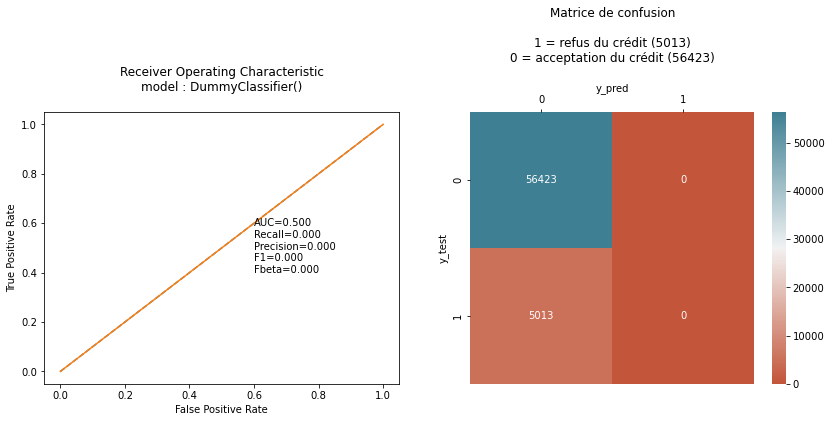

In [28]:
model = DummyClassifier()
model = make_pipeline(preprocessor, model)
resultats_choix_model = affichage_resultats(
    model, "not_balanced", X_train, y_train, X_test, y_test, resultats_choix_model)



Seuil optimal de discrimination:1.500

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56423
         1.0       0.00      0.00      0.00      5013

    accuracy                           0.92     61436
   macro avg       0.46      0.50      0.48     61436
weighted avg       0.84      0.92      0.88     61436

----------
f1-score : 0.000
fbeta-score : 0.000
precision : 0.000
recall : 0.000
auc : 0.500
custom score : -86498640.525


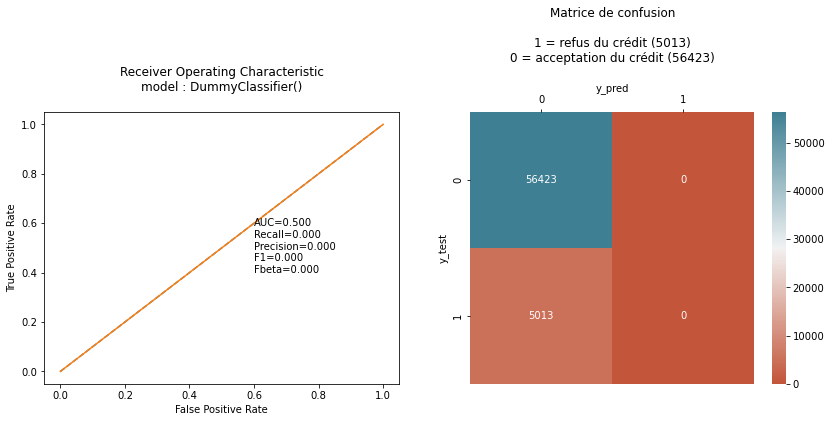

In [29]:
model = DummyClassifier()
model = make_pipeline(preprocessor, model)

resultats_choix_model = affichage_resultats(
    model, "balanced_SMOTE", X_train_balanced, y_train_balanced, X_test, y_test, resultats_choix_model)



Seuil optimal de discrimination:1.080

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56423
         1.0       0.00      0.00      0.00      5013

    accuracy                           0.92     61436
   macro avg       0.46      0.50      0.48     61436
weighted avg       0.84      0.92      0.88     61436

----------
f1-score : 0.000
fbeta-score : 0.000
precision : 0.000
recall : 0.000
auc : 0.500
custom score : -86498640.525


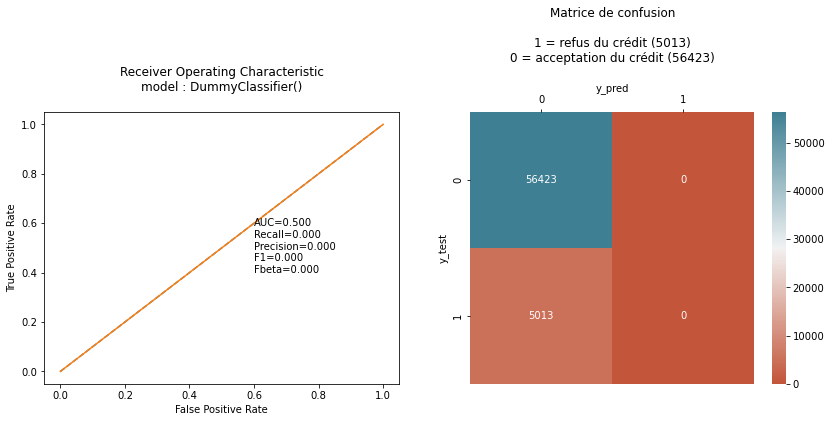

In [30]:
model = DummyClassifier()
model = make_pipeline(preprocessor, model)

resultats_choix_model = affichage_resultats(
    model, "balanced_class_weight", X_train, y_train, X_test, y_test, resultats_choix_model)



In [31]:
resultats_choix_model



,AUC,Recall,Precision,F1,Fbeta,custom_score,seuil_opt,durée_calculs_s
not_balanced_DummyClassifier(),0.5,0.0,0.0,0.0,0.0,-86498640.525499,1.080495,1.069041
balanced_SMOTE_DummyClassifier(),0.5,0.0,0.0,0.0,0.0,-86498640.525499,1.5,0.426263
balanced_class_weight_DummyClassifier(),0.5,0.0,0.0,0.0,0.0,-86498640.525499,1.080495,1.054209


  ## Regression logistique
  comme la feature selection a écarté les variables redondantes, il n'est pas nécessaire de mettre en place une régularisation dans le cadre de la regression logistique
  ### jeu de données non équilibré

Seuil optimal de discrimination:0.081

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56423
         1.0       0.57      0.02      0.04      5013

    accuracy                           0.92     61436
   macro avg       0.74      0.51      0.50     61436
weighted avg       0.89      0.92      0.88     61436

----------
f1-score : 0.038
fbeta-score : 0.020
precision : 0.566
recall : 0.020
auc : 0.758
custom score : -67586967.316


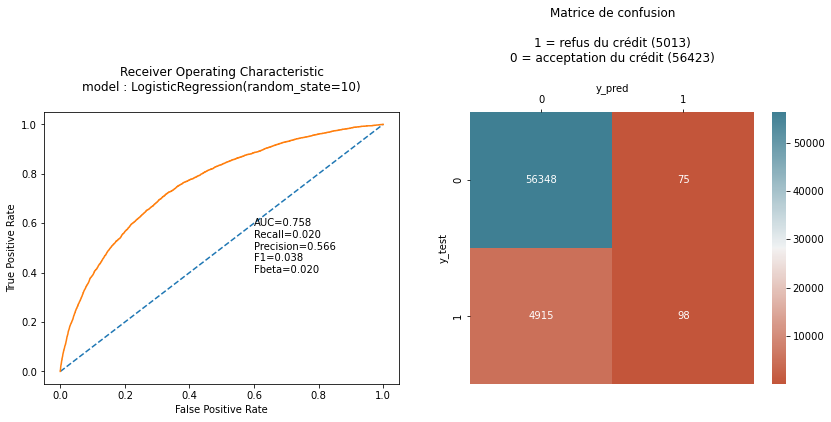

In [32]:

model = LogisticRegression(random_state=10)
lr = make_pipeline(preprocessor, model)
# lr.fit(X_train, y_train)

resultats_choix_model = affichage_resultats(
    lr, "not_balanced", X_train, y_train, X_test, y_test, resultats_choix_model)



  ### jeu de données équilibré (smote + undersampling)

Seuil optimal de discrimination:0.490

              precision    recall  f1-score   support

         0.0       0.96      0.69      0.81     56423
         1.0       0.17      0.69      0.27      5013

    accuracy                           0.69     61436
   macro avg       0.56      0.69      0.54     61436
weighted avg       0.90      0.69      0.76     61436

----------
f1-score : 0.270
fbeta-score : 0.678
precision : 0.167
recall : 0.693
auc : 0.757
custom score : 55097944.077


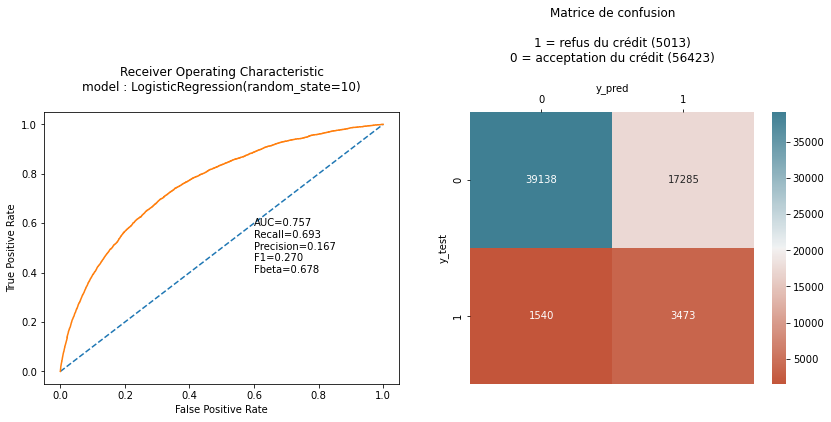

In [33]:
model = LogisticRegression(random_state=10)
lr = make_pipeline(preprocessor, model)

resultats_choix_model = affichage_resultats(
    lr, "balanced_SMOTE", X_train_balanced, y_train_balanced, X_test, y_test, resultats_choix_model)



  ### Equilibrage du jeu de données via class_weight

Seuil optimal de discrimination:0.489

              precision    recall  f1-score   support

         0.0       0.96      0.71      0.81     56423
         1.0       0.17      0.68      0.27      5013

    accuracy                           0.70     61436
   macro avg       0.57      0.69      0.54     61436
weighted avg       0.90      0.70      0.77     61436

----------
f1-score : 0.272
fbeta-score : 0.664
precision : 0.170
recall : 0.678
auc : 0.758
custom score : 64321392.615


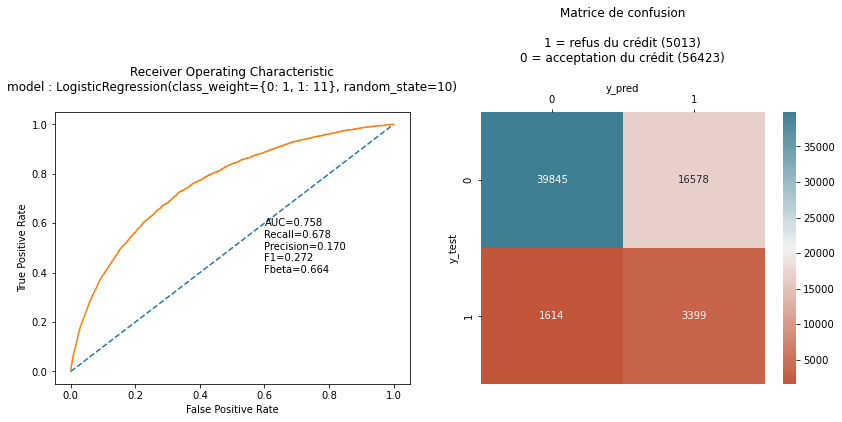

In [34]:
model = LogisticRegression(random_state=10, class_weight={
                           0: 1, 1: weight_positive})
lr = make_pipeline(preprocessor, model)

resultats_choix_model = affichage_resultats(
    lr, "balanced_class_weight", X_train, y_train, X_test, y_test, resultats_choix_model)



In [35]:
resultats_choix_model



,AUC,Recall,Precision,F1,Fbeta,custom_score,seuil_opt,durée_calculs_s
not_balanced_DummyClassifier(),0.5,0.0,0.0,0.0,0.0,-86498640.525499,1.080495,1.069041
balanced_SMOTE_DummyClassifier(),0.5,0.0,0.0,0.0,0.0,-86498640.525499,1.5,0.426263
balanced_class_weight_DummyClassifier(),0.5,0.0,0.0,0.0,0.0,-86498640.525499,1.080495,1.054209
not_balanced_LogisticRegression(random_state=10),0.757816,0.019549,0.566474,0.037794,0.01968,-67586967.316133,0.08149,4.501844
balanced_SMOTE_LogisticRegression(random_state=10),0.757276,0.692799,0.167309,0.269528,0.67811,55097944.076613,0.489671,0.955301
"balanced_class_weight_LogisticRegression(class_weight={0: 1, 1: 11}, random_state=10)",0.758067,0.678037,0.170146,0.272029,0.66436,64321392.615363,0.4891,4.779048


  # SGD Classifier
  ## jeu de données non équilibré

Seuil optimal de discrimination:0.066

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56423
         1.0       0.38      0.00      0.01      5013

    accuracy                           0.92     61436
   macro avg       0.65      0.50      0.48     61436
weighted avg       0.87      0.92      0.88     61436

----------
f1-score : 0.010
fbeta-score : 0.005
precision : 0.379
recall : 0.005
auc : 0.714
custom score : -82464500.365


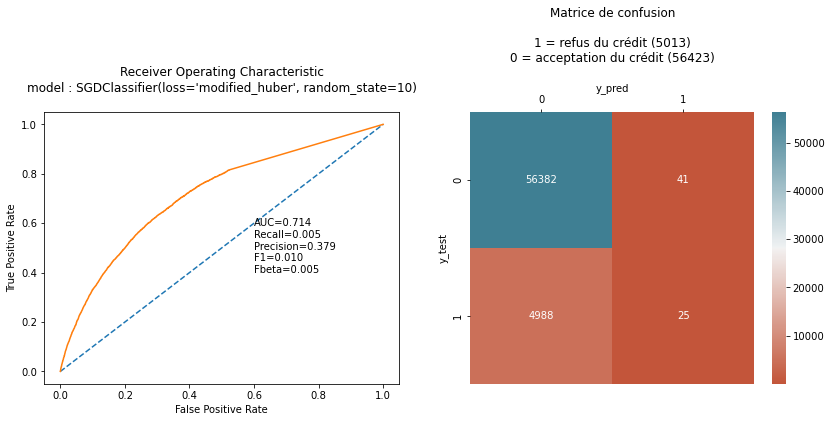

In [36]:

model = SGDClassifier(random_state=10, loss='modified_huber')
sgd = make_pipeline(preprocessor, model)

resultats_choix_model = affichage_resultats(
    sgd, "not_balanced", X_train, y_train, X_test, y_test, resultats_choix_model)



  ## jeu de données équilibré (SMOTE + undersampling)

Seuil optimal de discrimination:0.468

              precision    recall  f1-score   support

         0.0       0.96      0.66      0.78     56423
         1.0       0.15      0.67      0.24      5013

    accuracy                           0.66     61436
   macro avg       0.55      0.67      0.51     61436
weighted avg       0.89      0.66      0.74     61436

----------
f1-score : 0.245
fbeta-score : 0.651
precision : 0.150
recall : 0.666
auc : 0.719
custom score : -33293835.153


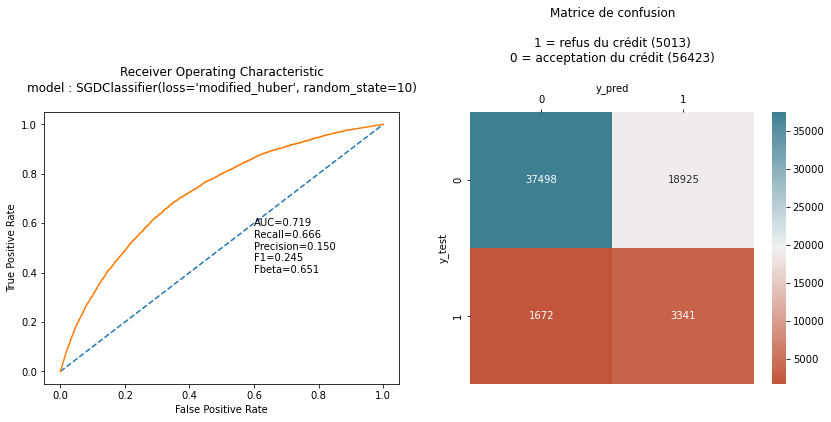

In [37]:
model = SGDClassifier(random_state=10, loss='modified_huber')
sgd = make_pipeline(preprocessor, model)

resultats_choix_model = affichage_resultats(
    sgd, "balanced_SMOTE", X_train_balanced, y_train_balanced, X_test, y_test, resultats_choix_model)



  ## Jeu de données équilibré (class_weight)

Seuil optimal de discrimination:0.066

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56423
         1.0       0.38      0.00      0.01      5013

    accuracy                           0.92     61436
   macro avg       0.65      0.50      0.48     61436
weighted avg       0.87      0.92      0.88     61436

----------
f1-score : 0.010
fbeta-score : 0.005
precision : 0.379
recall : 0.005
auc : 0.714
custom score : -82464500.365


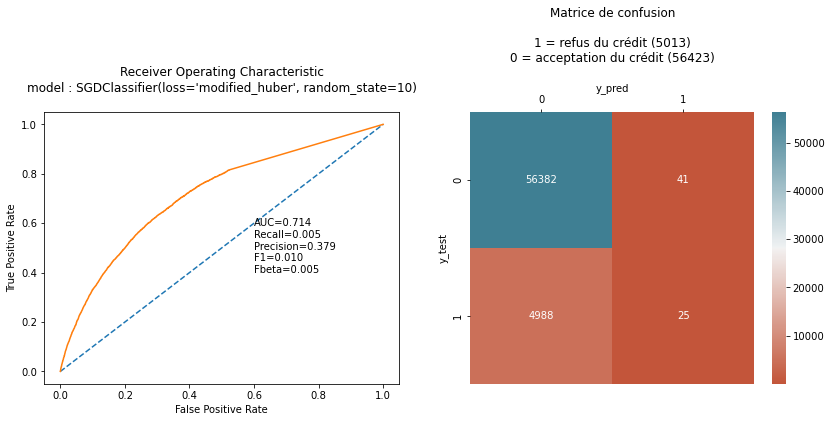

In [38]:
model = SGDClassifier(random_state=10, loss='modified_huber')
sgd = make_pipeline(preprocessor, model)

resultats_choix_model = affichage_resultats(
    sgd, "balanced_class_weight", X_train, y_train, X_test, y_test, resultats_choix_model)



  ## Random Forest
  ### Jeu de données non équilibré

Seuil optimal de discrimination:0.490

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56423
         1.0       0.71      0.00      0.00      5013

    accuracy                           0.92     61436
   macro avg       0.82      0.50      0.48     61436
weighted avg       0.90      0.92      0.88     61436

----------
f1-score : 0.002
fbeta-score : 0.001
precision : 0.714
recall : 0.001
auc : 0.726
custom score : -85467750.064


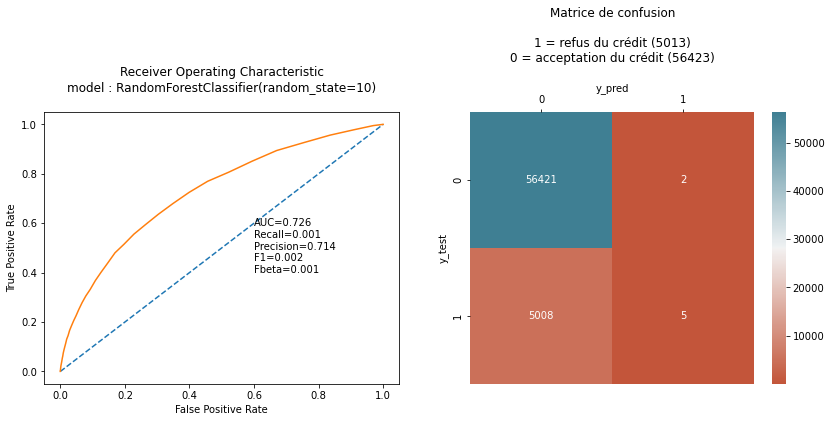

In [39]:

model = RandomForestClassifier(random_state=10)
rf = make_pipeline(preprocessor, model)

resultats_choix_model = affichage_resultats(
    rf, "not_balanced", X_train, y_train, X_test, y_test, resultats_choix_model)



  ### jeu de données équilibré (SMOTE + undersampling)

Seuil optimal de discrimination:0.560

              precision    recall  f1-score   support

         0.0       0.96      0.74      0.84     56423
         1.0       0.18      0.63      0.28      5013

    accuracy                           0.73     61436
   macro avg       0.57      0.69      0.56     61436
weighted avg       0.89      0.73      0.79     61436

----------
f1-score : 0.278
fbeta-score : 0.619
precision : 0.179
recall : 0.630
auc : 0.751
custom score : 85450655.708


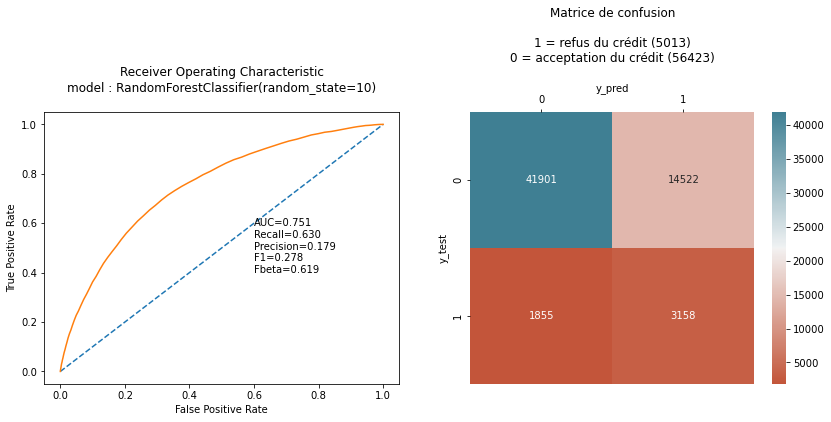

In [40]:
model = RandomForestClassifier(random_state=10)
rf = make_pipeline(preprocessor, model)

resultats_choix_model = affichage_resultats(
    rf, "balanced_SMOTE", X_train_balanced, y_train_balanced, X_test, y_test, resultats_choix_model)



  ### Equilibrage du jeu de données via class_weight

Seuil optimal de discrimination:0.490

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56423
         1.0       0.47      0.00      0.00      5013

    accuracy                           0.92     61436
   macro avg       0.69      0.50      0.48     61436
weighted avg       0.88      0.92      0.88     61436

----------
f1-score : 0.003
fbeta-score : 0.002
precision : 0.471
recall : 0.002
auc : 0.741
custom score : -85058822.576


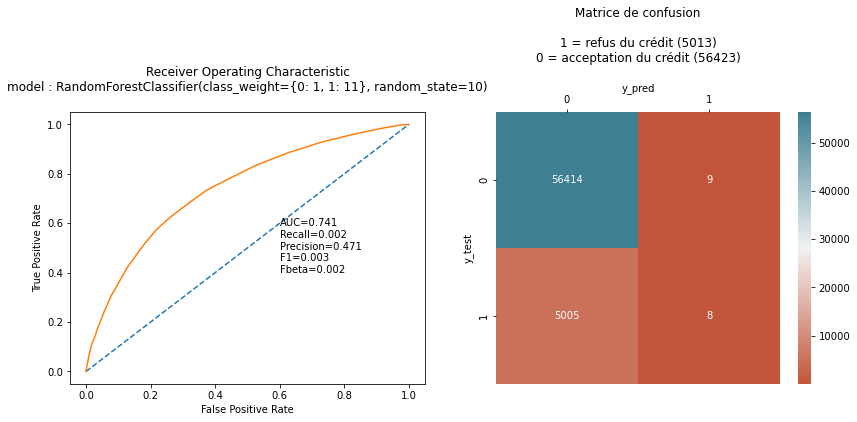

In [41]:
model = RandomForestClassifier(random_state=10, class_weight={
                               0: 1, 1: weight_positive})
rf = make_pipeline(preprocessor, model)

resultats_choix_model = affichage_resultats(
    rf, "balanced_class_weight", X_train, y_train, X_test, y_test, resultats_choix_model)



  ## LightGBM
  ### Jeu de données non équilibré

Seuil optimal de discrimination:0.086

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96     56423
         1.0       0.59      0.03      0.06      5013

    accuracy                           0.92     61436
   macro avg       0.76      0.51      0.51     61436
weighted avg       0.89      0.92      0.88     61436

----------
f1-score : 0.057
fbeta-score : 0.030
precision : 0.593
recall : 0.030
auc : 0.774
custom score : -57125908.048


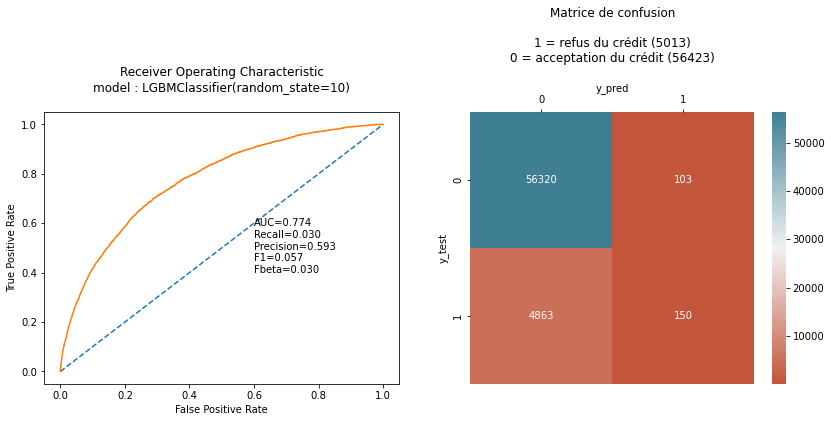

In [42]:
model = LGBMClassifier(random_state=10)
lgbm = make_pipeline(preprocessor, model)

resultats_choix_model = affichage_resultats(
    lgbm, "not_balanced", X_train, y_train, X_test, y_test, resultats_choix_model)



  ### Jeu de données équilibré (SMOTE + undersampling)

Seuil optimal de discrimination:0.500

              precision    recall  f1-score   support

         0.0       0.96      0.76      0.85     56423
         1.0       0.19      0.64      0.30      5013

    accuracy                           0.75     61436
   macro avg       0.58      0.70      0.57     61436
weighted avg       0.90      0.75      0.80     61436

----------
f1-score : 0.296
fbeta-score : 0.628
precision : 0.193
recall : 0.638
auc : 0.771
custom score : 134888756.881


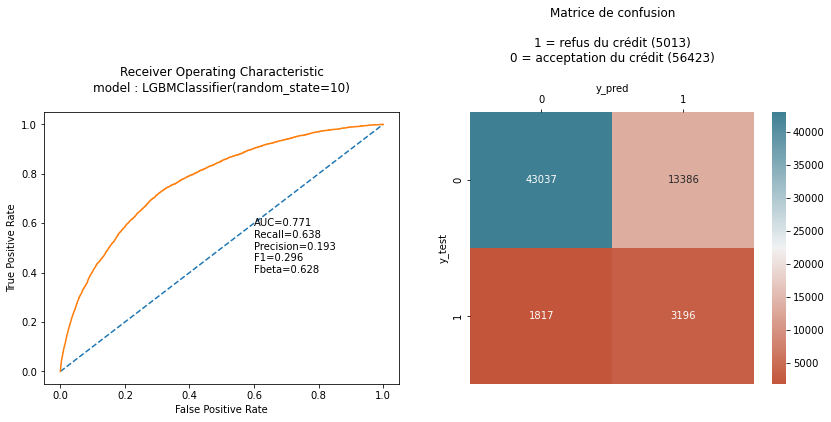

In [43]:
model = LGBMClassifier(random_state=10)
lgbm = make_pipeline(preprocessor, model)

resultats_choix_model = affichage_resultats(
    lgbm, "balanced_SMOTE", X_train_balanced, y_train_balanced, X_test, y_test, resultats_choix_model)



  ### Jeu de données équilibré (class_weight)

Seuil optimal de discrimination:0.453

              precision    recall  f1-score   support

         0.0       0.96      0.73      0.83     56423
         1.0       0.18      0.68      0.29      5013

    accuracy                           0.73     61436
   macro avg       0.57      0.70      0.56     61436
weighted avg       0.90      0.73      0.79     61436

----------
f1-score : 0.289
fbeta-score : 0.665
precision : 0.184
recall : 0.677
auc : 0.776
custom score : 117571432.633


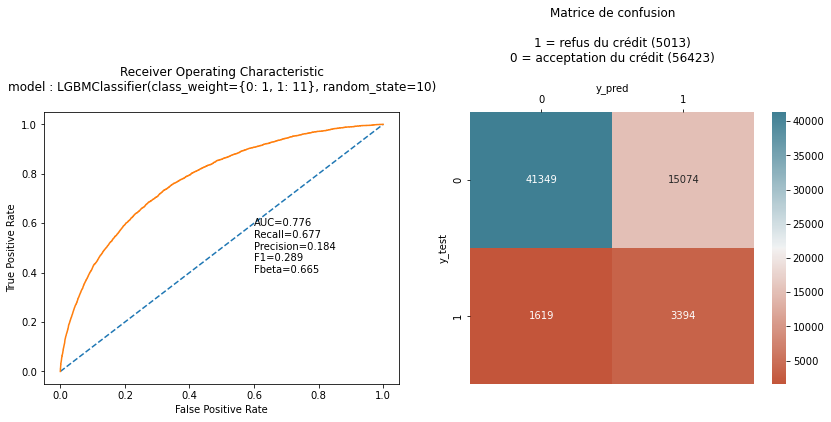

In [44]:
model = LGBMClassifier(random_state=10, class_weight={
                       0: 1, 1: weight_positive})
lgbm = make_pipeline(preprocessor, model)

resultats_choix_model = affichage_resultats(
    lgbm, "balanced_class_weight", X_train, y_train, X_test, y_test, resultats_choix_model)



In [45]:
resultats_choix_model.sort_values(by="custom_score", ascending=False)


,AUC,Recall,Precision,F1,Fbeta,custom_score,seuil_opt,durée_calculs_s
balanced_SMOTE_LGBMClassifier(random_state=10),0.771122,0.637542,0.192739,0.295994,0.627554,134888756.881265,0.499687,2.110939
"balanced_class_weight_LGBMClassifier(class_weight={0: 1, 1: 11}, random_state=10)",0.776074,0.67704,0.183777,0.289085,0.664735,117571432.632556,0.453245,7.379675
balanced_SMOTE_RandomForestClassifier(random_state=10),0.750931,0.629962,0.17862,0.278324,0.619172,85450655.708109,0.56,20.350991
"balanced_class_weight_LogisticRegression(class_weight={0: 1, 1: 11}, random_state=10)",0.758067,0.678037,0.170146,0.272029,0.66436,64321392.615363,0.4891,4.779048
balanced_SMOTE_LogisticRegression(random_state=10),0.757276,0.692799,0.167309,0.269528,0.67811,55097944.076613,0.489671,0.955301
"balanced_SMOTE_SGDClassifier(loss='modified_huber', random_state=10)",0.719219,0.666467,0.150049,0.24495,0.651015,-33293835.152722,0.467836,3.820317
not_balanced_LGBMClassifier(random_state=10),0.773613,0.029922,0.592885,0.056969,0.030119,-57125908.048371,0.086285,7.017543
not_balanced_LogisticRegression(random_state=10),0.757816,0.019549,0.566474,0.037794,0.01968,-67586967.316133,0.08149,4.501844
"not_balanced_SGDClassifier(loss='modified_huber', random_state=10)",0.713883,0.004987,0.378788,0.009844,0.005021,-82464500.365467,0.066353,7.263745
"balanced_class_weight_SGDClassifier(loss='modified_huber', random_state=10)",0.713883,0.004987,0.378788,0.009844,0.005021,-82464500.365467,0.066353,7.283479


  Les deux meilleurs classifieurs (selon le score customisé) sont LGBMClassifier et RandomForest, à chaque fois avec des données équilibrées. Je vais donc chercher à optimiser ces deux classifieurs en testant les deux méthodes d'équilibrage des données

  # Optimisation des hyperparamètres
  # metric = fbeta

In [46]:
# création du tableau qui va stocker les résultats des différentes optimisations
resultats_optimisation = pd.DataFrame(
    columns=['best_params', 'AUC', 'Recall', 'Precision', 'F1', 'Fbeta', 'custom_score', 'seuil_opt', 'duree_calculs_s', 'duree_refit'])

# configuration de la fonction d'évaluation
fbeta_scorer = make_scorer(fbeta_score, beta=12)

# LGBM : configuration des paramètres
max_depth = [5, 10, 15]
num_leaves = [5, 15, 25, 35]
learning_rate = [0.01, 0.1, 1]
reg_alpha = [0, 0.1, 1]
reg_lambda = [0, 0.1, 1]

param_grid_lgbm = {'lgbmclassifier__max_depth': max_depth,
                   'lgbmclassifier__num_leaves': num_leaves,
                   'lgbmclassifier__learning_rate': learning_rate,
                   'lgbmclassifier__reg_alpha': reg_alpha,
                   'lgbmclassifier__reg_lambda': reg_lambda,
                   }

# RandomForestClassifier : configuration des paramètres à tester
n_estimator_range = [10, 100, 500]
max_depth_range = [5, 10, 15]
max_features_range = ['auto', 'sqrt', 'log2']

param_grid_rf = {"randomforestclassifier__n_estimators": n_estimator_range,
                 "randomforestclassifier__max_depth": max_depth_range,
                 "randomforestclassifier__max_features": max_features_range}



In [47]:
# Fonction pour trouver les paramètres optimaux et stocker les résultats dans un tableau


def optimisation_param(model_opt, run, X_train, y_train, X_test, y_test, resultats, beta=12):
    start = timeit.default_timer()
    # entrainement du modèle
    model_opt.fit(X_train, y_train)
    elapsed = timeit.default_timer() - start
    # Extraction du seuil optimal de décision
    # y_proba: Probabilités de défaut de paiement prédites pour les données d'entraînement
    y_proba = model_opt.predict_proba(X_train)[:, 1]
    # fpr, tpr, thresholds: False Positive Rate, True Positive Rate, Seuils, pour les données d'entraînement
    fpr, tpr, thresholds = roc_curve(y_train, y_proba, pos_label=1)
    # best_tresh: Seuil optimal pour discriminer les candidatures = point d'inflexion de la courbe ROC
    best_thresh = thresholds[np.argmax(tpr - fpr)]
    print("Seuil optimal de discrimination:%.3f\n" % best_thresh)
    # prédiction du modèle sur le jeu de test
    y_pred = model_opt.predict(X_test)
    # extraction des probabilités
    y_proba = model_opt.predict_proba(X_test)[:, 1]
    # extraction des variables false positive rate, true positive rate et thresholds
    fpr, tpr, thresholds = roc_curve(y_true=y_test, y_score=y_proba)
    # Calcul de la matrice de confusion
    conf_mat = confusion_matrix(y_test, y_pred)

    # Nombre de prêt accordés / refusés dans la base de test
    nb_pret_accorde = y_test.value_counts()[0]
    nb_pret_refuse = y_test.value_counts()[1]

    # Calcul des scores
    f1 = f1_score(y_true=y_test, y_pred=y_pred)
    precision = precision_score(y_true=y_test, y_pred=y_pred)
    recall = recall_score(y_true=y_test, y_pred=y_pred)
    auc_score = auc(x=fpr, y=tpr)
    fbeta = fbeta_score(y_true=y_test, y_pred=y_pred, beta=beta)
    custom = custom_metric(y_true=y_test, y_pred=y_pred)

    # Affichage du rapport de classification
    print(classification_report(y_true=y_test, y_pred=y_pred))
    # Affichage des scores
    print('-'*10)
    print("f1-score : {:.3f}".format(f1))
    print("fbeta-score : {:.3f}".format(fbeta))
    print("precision : {:.3f}".format(precision))
    print("recall : {:.3f}".format(recall))
    print("auc : {:.3f}".format(auc_score))
    print("custom score : {:.3f}".format(custom))

    # Stockage des résultats
    resultats.loc[run, "AUC"] = auc_score
    resultats.loc[run, "Recall"] = recall
    resultats.loc[run, 'Precision'] = precision
    resultats.loc[run, "F1"] = f1
    resultats.loc[run, "Fbeta"] = fbeta
    resultats.loc[run, "seuil_opt"] = best_thresh
    resultats.loc[run, "duree_calculs_s"] = elapsed
    resultats.loc[run, "duree_refit"] = float(model_opt.refit_time_)
    resultats.loc[run, 'best_params'] = str(model_opt.best_params_)
    resultats.loc[run, "custom_score"] = custom

    # affichage de la courbe ROC et de la matrice de confusion
    my_cmap = sns.diverging_palette(20, 220, as_cmap=True)
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr)
    plt.title("Receiver Operating Characteristic\nmodel : {}\n".format(run))
    plt.text(0.6, 0.4, "AUC=%.3f\nRecall=%.3f\nPrecision=%.3f\nF1=%.3f\nFbeta=%.3f" % (
        auc_score, recall, precision, f1, fbeta))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    plt.subplot(1, 2, 2)
    axes = plt.gca()
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap=my_cmap)
    plt.title("Matrice de confusion\n\n1 = refus du crédit ({})\n0 = acceptation du crédit ({})\n".format(
        nb_pret_refuse, nb_pret_accorde))
    axes.xaxis.set_ticks_position('top')
    axes.xaxis.set_label_position('top')
    axes.set_frame_on('False')
    plt.xlabel("y_pred")
    plt.ylabel("y_test")
    return resultats, model_opt



## SMOTE+undersampling
  ### RandomForest

Seuil optimal de discrimination:0.515

              precision    recall  f1-score   support

         0.0       0.96      0.73      0.83     56423
         1.0       0.18      0.66      0.28      5013

    accuracy                           0.72     61436
   macro avg       0.57      0.69      0.56     61436
weighted avg       0.90      0.72      0.78     61436

----------
f1-score : 0.280
fbeta-score : 0.645
precision : 0.178
recall : 0.657
auc : 0.758
custom score : 90874656.102


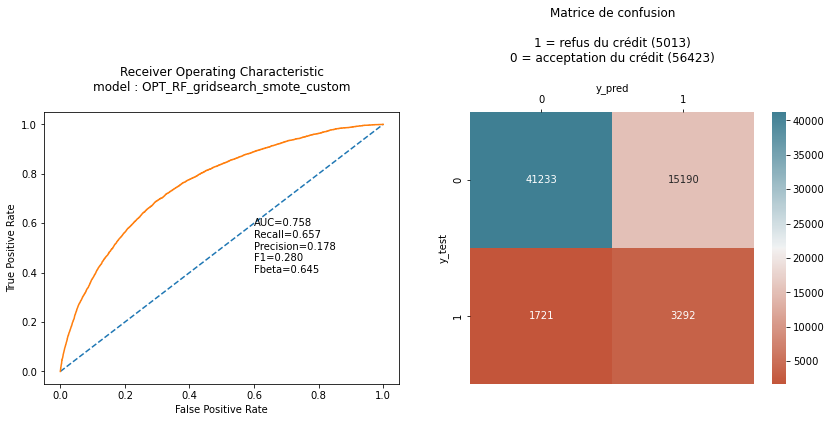

In [48]:
# configuration modèle
model = RandomForestClassifier(random_state=10)
rf = make_pipeline(preprocessor, model)

gridsearch_rf_smote = GridSearchCV(
    estimator=rf, param_grid=param_grid_rf, scoring=custom_score, cv=5)
resultats_optimisation, gridsearch_rf_smote_opt_custom = optimisation_param(
    gridsearch_rf_smote, "OPT_RF_gridsearch_smote_custom", X_train_balanced, y_train_balanced, X_test, y_test, resultats_optimisation)



In [49]:
resultats_optimisation


,best_params,AUC,Recall,Precision,F1,Fbeta,custom_score,seuil_opt,duree_calculs_s,duree_refit
OPT_RF_gridsearch_smote_custom,"{'randomforestclassifier__max_depth': 15, 'ran...",0.757724,0.656693,0.178119,0.28023,0.644746,90874656.101878,0.514518,2324.559956,91.238685


  ### LGBM

Seuil optimal de discrimination:0.501

              precision    recall  f1-score   support

         0.0       0.96      0.76      0.85     56423
         1.0       0.19      0.64      0.30      5013

    accuracy                           0.75     61436
   macro avg       0.58      0.70      0.57     61436
weighted avg       0.90      0.75      0.80     61436

----------
f1-score : 0.297
fbeta-score : 0.631
precision : 0.193
recall : 0.642
auc : 0.772
custom score : 137711311.072


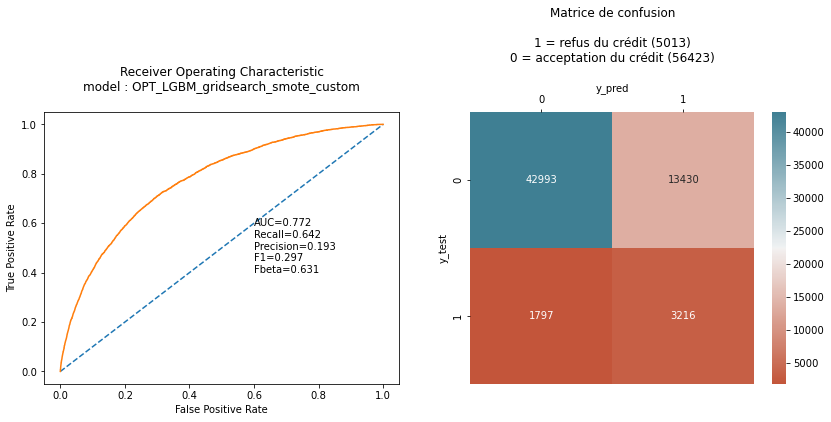

In [50]:

# configuration modèle
model = LGBMClassifier(random_state=10)
lgbm = make_pipeline(preprocessor, model)

gridsearch_lgbm_smote = GridSearchCV(
    estimator=lgbm, param_grid=param_grid_lgbm, scoring=custom_score, cv=5)
resultats_optimisation, gridsearch_lgbm_smote_opt_custom = optimisation_param(
    gridsearch_lgbm_smote, "OPT_LGBM_gridsearch_smote_custom", X_train_balanced, y_train_balanced, X_test, y_test, resultats_optimisation)


In [51]:
resultats_optimisation



,best_params,AUC,Recall,Precision,F1,Fbeta,custom_score,seuil_opt,duree_calculs_s,duree_refit
OPT_RF_gridsearch_smote_custom,"{'randomforestclassifier__max_depth': 15, 'ran...",0.757724,0.656693,0.178119,0.28023,0.644746,90874656.101878,0.514518,2324.559956,91.238685
OPT_LGBM_gridsearch_smote_custom,"{'lgbmclassifier__learning_rate': 0.1, 'lgbmcl...",0.771967,0.641532,0.1932,0.296967,0.631427,137711311.0723,0.500987,2685.493277,2.081


  ## Class_weight
  ### RandomForest

Seuil optimal de discrimination:0.493

              precision    recall  f1-score   support

         0.0       0.96      0.71      0.81     56423
         1.0       0.16      0.65      0.26      5013

    accuracy                           0.70     61436
   macro avg       0.56      0.68      0.54     61436
weighted avg       0.89      0.70      0.77     61436

----------
f1-score : 0.261
fbeta-score : 0.633
precision : 0.164
recall : 0.646
auc : 0.736
custom score : 30891630.384


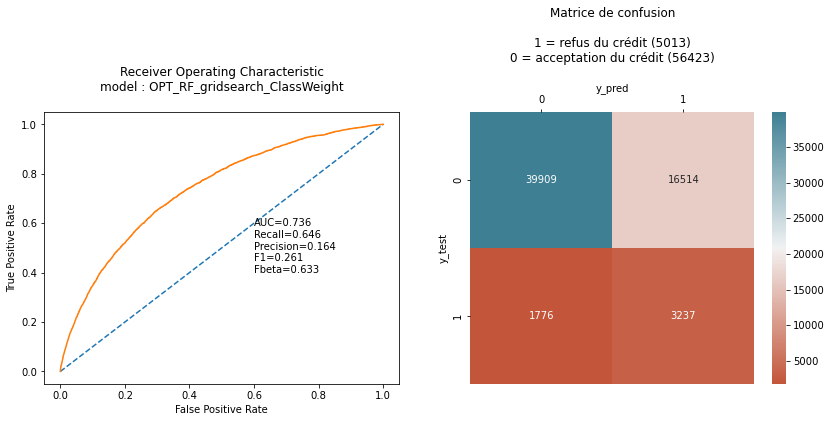

In [52]:
# configuration modèle
model = RandomForestClassifier(random_state=10, class_weight={
    0: 1, 1: weight_positive})
rf = make_pipeline(preprocessor, model)

gridsearch_rf_CW = GridSearchCV(
    estimator=rf, param_grid=param_grid_rf, scoring=fbeta_scorer, cv=5)
resultats_optimisation, gridsearch_rf_CW_opt = optimisation_param(
    gridsearch_rf_CW, "OPT_RF_gridsearch_ClassWeight", X_train, y_train, X_test, y_test, resultats_optimisation)



  ### LGBM

Seuil optimal de discrimination:0.469

              precision    recall  f1-score   support

         0.0       0.96      0.74      0.83     56423
         1.0       0.18      0.67      0.29      5013

    accuracy                           0.73     61436
   macro avg       0.57      0.70      0.56     61436
weighted avg       0.90      0.73      0.79     61436

----------
f1-score : 0.290
fbeta-score : 0.659
precision : 0.185
recall : 0.671
auc : 0.776
custom score : 119019038.532


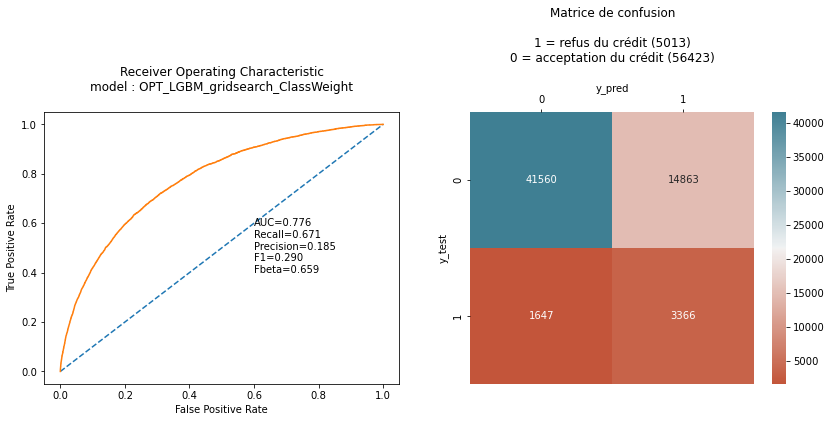

In [53]:
# configuration modèle
model = LGBMClassifier(random_state=10, class_weight={
                       0: 1, 1: weight_positive})
lgbm = make_pipeline(preprocessor, model)

gridsearch_lgbm_CW = GridSearchCV(
    estimator=lgbm, param_grid=param_grid_lgbm, scoring=custom_score, cv=5)
resultats_optimisation, gridsearch_lgbm_CW_opt = optimisation_param(
    gridsearch_lgbm_CW, "OPT_LGBM_gridsearch_ClassWeight", X_train, y_train, X_test, y_test, resultats_optimisation)



In [55]:
resultats_optimisation.sort_values(by='custom_score', ascending=False)


,best_params,AUC,Recall,Precision,F1,Fbeta,custom_score,seuil_opt,duree_calculs_s,duree_refit
OPT_LGBM_gridsearch_smote_custom,"{'lgbmclassifier__learning_rate': 0.1, 'lgbmcl...",0.771967,0.641532,0.1932,0.296967,0.631427,137711311.0723,0.500987,2685.493277,2.081
OPT_LGBM_gridsearch_ClassWeight,"{'lgbmclassifier__learning_rate': 0.1, 'lgbmcl...",0.775779,0.671454,0.184651,0.289648,0.659464,119019038.531755,0.468999,9353.451724,7.189517
OPT_RF_gridsearch_smote_custom,"{'randomforestclassifier__max_depth': 15, 'ran...",0.757724,0.656693,0.178119,0.28023,0.644746,90874656.101878,0.514518,2324.559956,91.238685
OPT_RF_gridsearch_ClassWeight,"{'randomforestclassifier__max_depth': 5, 'rand...",0.736034,0.645721,0.16389,0.261428,0.632889,30891630.384399,0.4933,11166.672492,150.296


 # Choix modèle

 # Feature importance

In [174]:
# choix modèle :
best_pipeline = gridsearch_lgbm_smote_opt_custom.best_estimator_


In [68]:
gridsearch_lgbm_smote_opt_custom.best_estimator_[1]

LGBMClassifier(max_depth=15, num_leaves=35, random_state=10, reg_alpha=0,
               reg_lambda=0)

In [176]:
# job_dir: Répertoire dans lequel enregistrer les fichier joblib
job_dir = './JOBLIB'
dump(data, job_dir + '/data.joblib')
dump(best_pipeline, job_dir + '/pipeline.joblib')


['./JOBLIB/pipeline.joblib']

In [113]:
# evaluaton overfit
evaluation = gridsearch_lgbm_smote_opt_custom.best_estimator_
X_train_transformed = evaluation[:-1].fit_transform(X_train_balanced)
X_test_transformed = evaluation[:-1].transform(X_test)
eval = evaluation[-1].fit(X=X_train_transformed,
                    y=y_train_balanced,
                    eval_set=[(X_train_transformed, y_train_balanced),
                                (X_test_transformed, y_test)],
                    eval_metric='custom_score')

[1]	training's binary_logloss: 0.676108	valid_1's binary_logloss: 0.677136
[2]	training's binary_logloss: 0.661843	valid_1's binary_logloss: 0.663756
[3]	training's binary_logloss: 0.649582	valid_1's binary_logloss: 0.652354
[4]	training's binary_logloss: 0.639147	valid_1's binary_logloss: 0.642448
[5]	training's binary_logloss: 0.630377	valid_1's binary_logloss: 0.634319
[6]	training's binary_logloss: 0.622254	valid_1's binary_logloss: 0.626733
[7]	training's binary_logloss: 0.61525	valid_1's binary_logloss: 0.620168
[8]	training's binary_logloss: 0.608386	valid_1's binary_logloss: 0.614135
[9]	training's binary_logloss: 0.602032	valid_1's binary_logloss: 0.608356
[10]	training's binary_logloss: 0.596262	valid_1's binary_logloss: 0.60295
[11]	training's binary_logloss: 0.591277	valid_1's binary_logloss: 0.598374
[12]	training's binary_logloss: 0.586734	valid_1's binary_logloss: 0.59428
[13]	training's binary_logloss: 0.582565	valid_1's binary_logloss: 0.590718
[14]	training's binary_l

<AxesSubplot:>

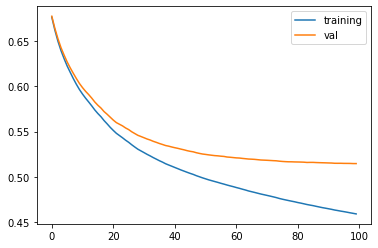

In [124]:

training = pd.DataFrame(eval.evals_result_['training'])
val = pd.DataFrame(eval.evals_result_['valid_1'])
training.columns = ['training']
val.columns = ['val']
df = pd.concat([training, val], axis=1)
df.plot()


In [58]:
job_dir = './JOBLIB'
test_best_model = load(job_dir+'/model.joblib')
test_best_gridsearch = load(job_dir + '/gridsearch.joblib')


In [59]:
test_best_gridsearch


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['CNT_CHILDREN',
                                                                          'AMT_INCOME_TOTAL',
                                                                          'AMT_CREDIT',
                                                                          'AMT_ANNUITY',
                                                                          'AMT_GOODS_PRICE',
                                                                          'REGION_POPULATION_RELATIVE',
                                                                          'DAYS_BIRTH',
                                                                          'DAYS_EMPLOYED',
                                                                          'DAYS_REGISTRATION',
                                                                          'DAYS_ID_PUBLISH',
                                                                          'REGION_R...
                                        LGBMClassifier(random_state=10))]),
             param_grid={'lgbmclassifier__learning_rate': [0.01, 0.1, 1],
                         'lgbmclassifier__max_depth': [5, 10, 15],
                         'lgbmclassifier__num_leaves': [5, 15, 25, 35],
                         'lgbmclassifier__reg_alpha': [0, 0.1, 1],
                         'lgbmclassifier__reg_lambda': [0, 0.1, 1]},
             scoring=make_scorer(custom_metric, dict_param={'gain_si_rembourse': 18069.550758523692, 'perte_si_non_rembourse': 220633.73288922428}))

In [60]:


def feature_importance_LGBM(model, nb_features_to_plot):
    best_model = model.best_estimator_[1]
    nom_features = model.feature_names_in_
    # print(best_model.feature_importances_)
    feature_importance = pd.DataFrame(
        best_model.feature_importances_, index=nom_features, columns=['score'])
    feature_importance = feature_importance.sort_values(
        by='score', ascending=False).reset_index()
    # print(feature_importance)
    top = feature_importance.head(nb_features_to_plot)
    hauteur = int(top.shape[0]/4)
    fig = plt.figure(figsize=(8, hauteur))
    sns.barplot(data=top, x='score', y='index')

# def feature_importance_LR(model, nb_features_to_plot):
#     best_model = model.best_estimator_[1]
#     nom_features = model.feature_names_in_
#     feature_importance = pd.DataFrame(best_model.coef_, columns=nom_features, index=['score']).T
#     feature_importance = feature_importance.sort_values(by='score', ascending=False).reset_index()
#     top = feature_importance.head(nb_features_to_plot)
#     hauteur = int(top.shape[0]/4)
#     fig = plt.figure(figsize=(8, hauteur))
#     sns.barplot(data=top, x='score', y='index')



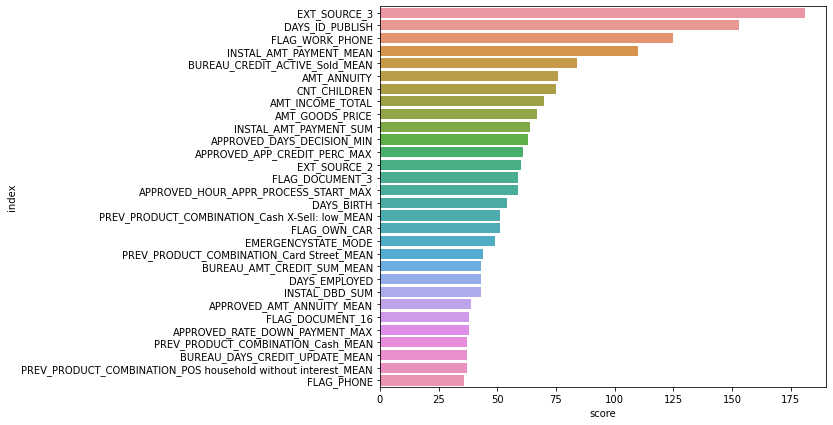

In [61]:
feature_importance_LGBM(test_best_gridsearch, 30)


 # Choix du seuil de décision

In [62]:
model = gridsearch_lgbm_smote_opt_custom
y_proba = model.predict_proba(X_test)[:, 1]
masque = y_proba > 0.45
masque
y_pred = y_proba.copy()
y_pred[masque] = 1
y_pred[~masque] = 0
pd.DataFrame(y_pred).value_counts()
custom_metric(y_true=y_test, y_pred=y_pred)


88081166.9859873

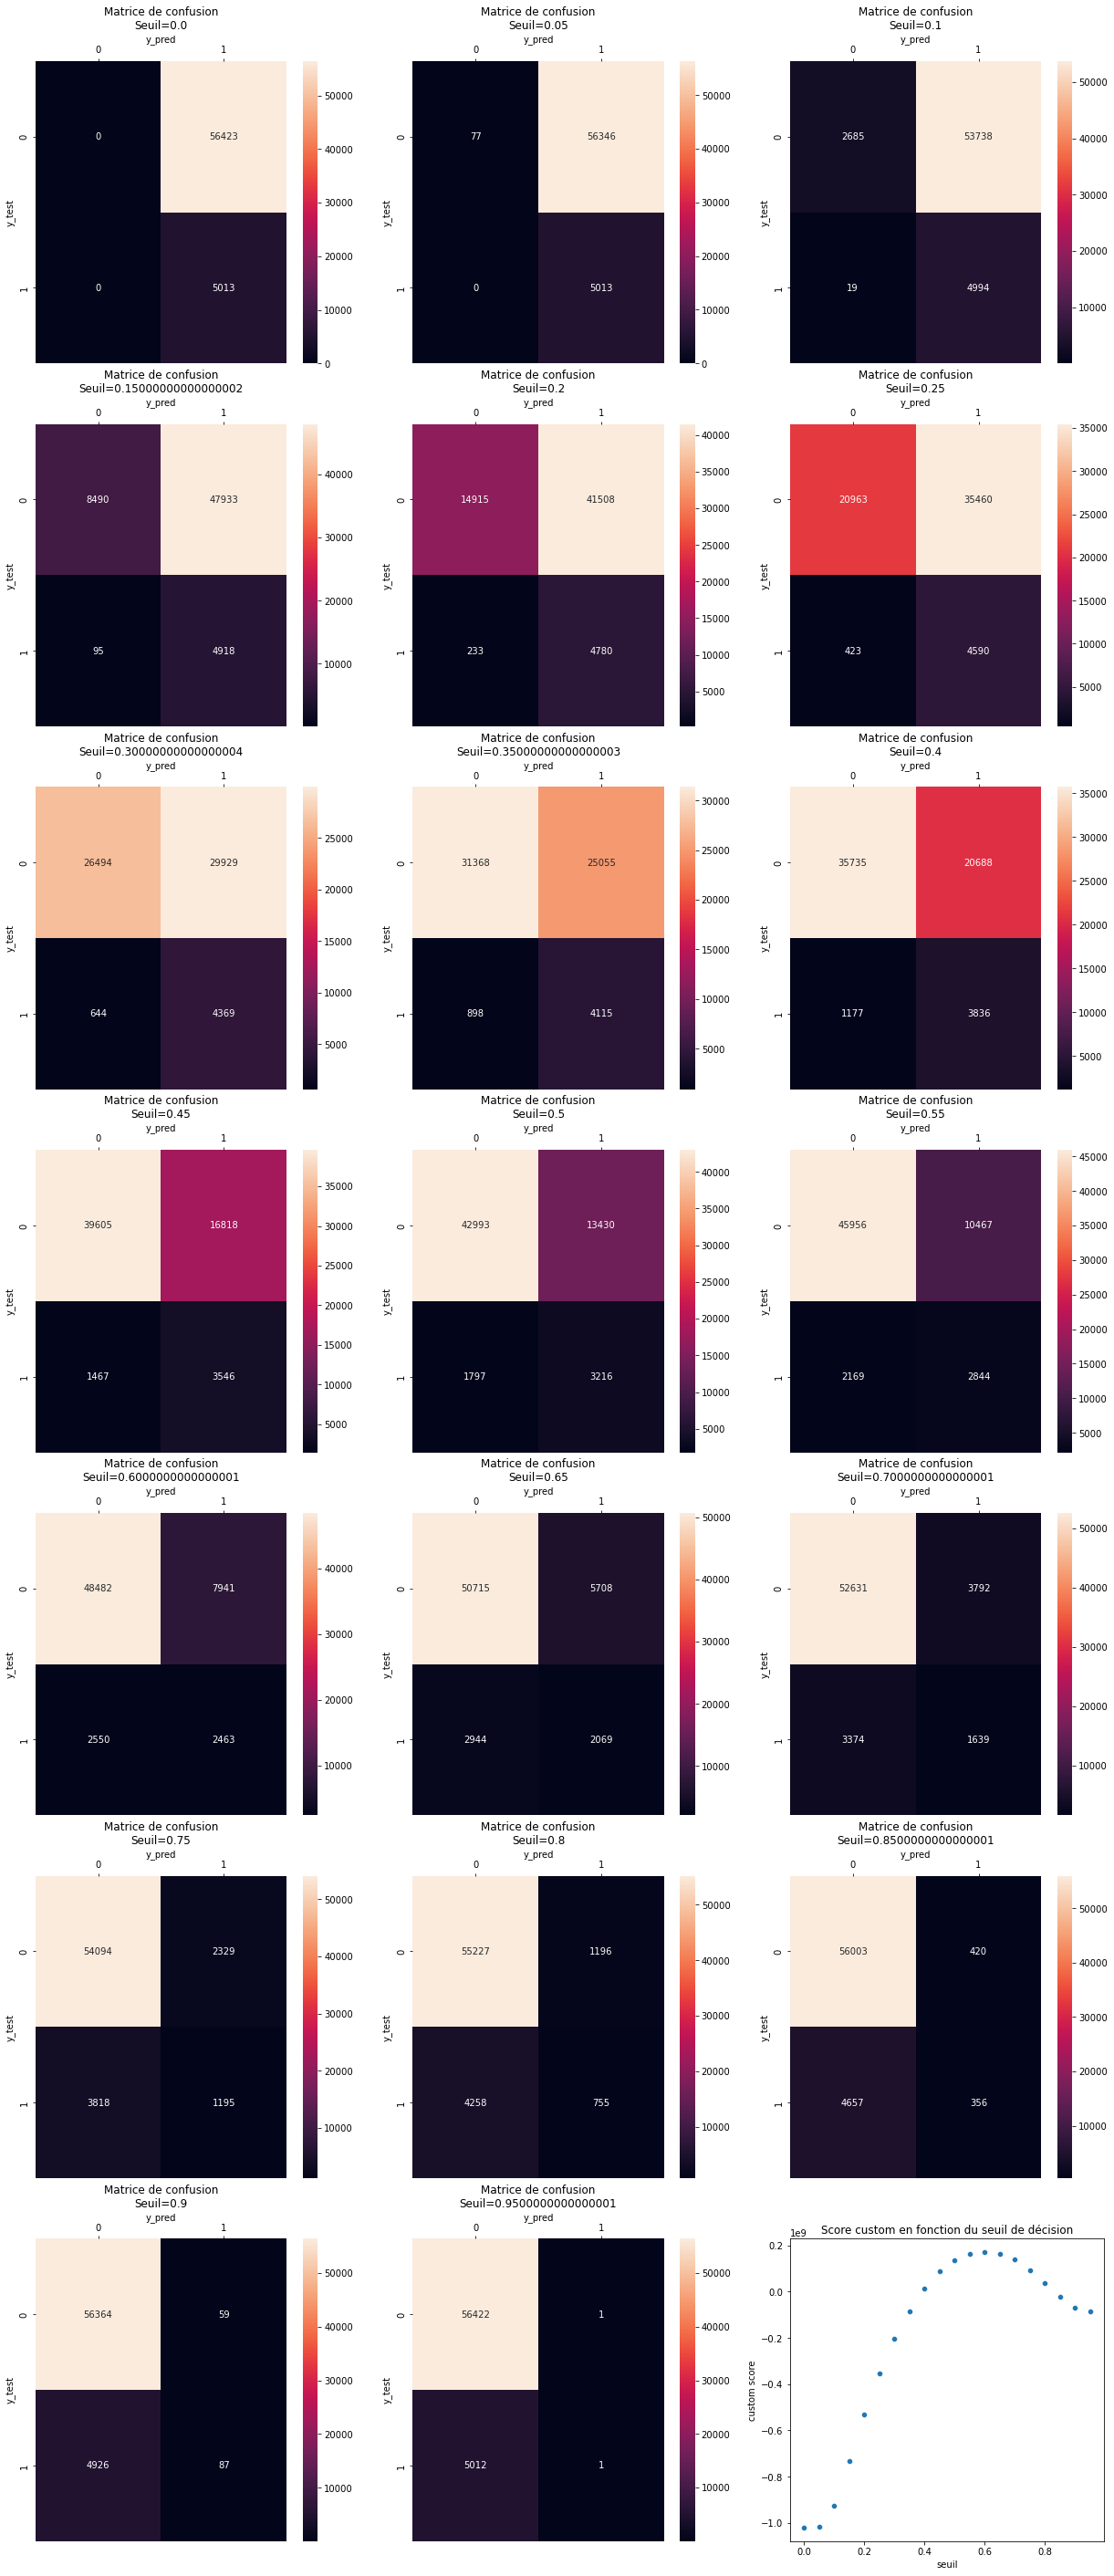

In [63]:
model = gridsearch_lgbm_smote_opt_custom
y_proba = model.predict_proba(X_test)[:, 1]
choix_seuil = pd.DataFrame()
plt.figure(figsize=(21, 50))
compteur = 1
for seuil in np.arange(0, 1, 0.05):
    masque = y_proba > seuil
    y_pred = y_proba.copy()
    y_pred[masque] = 1
    y_pred[~masque] = 0
    score = custom_metric(y_true=y_test, y_pred=y_pred)
    result = pd.DataFrame([seuil, score]).T
    # Calcul de la matrice de confusion
    conf_mat = confusion_matrix(y_test, y_pred)
    plt.subplot(7, 3, compteur)
    axes = plt.gca()
    sns.heatmap(conf_mat, annot=True, fmt='d')
    plt.title("Matrice de confusion\nSeuil={}".format(seuil))
    axes.xaxis.set_ticks_position('top')
    axes.xaxis.set_label_position('top')
    axes.set_frame_on('False')
    plt.xlabel("y_pred")
    plt.ylabel("y_test")
    compteur += 1
    choix_seuil = choix_seuil.append(result)

choix_seuil.columns = ['seuil', 'custom score']
choix_seuil = choix_seuil.reset_index(drop=True)
plt.subplot(7, 3, 21)
sns.scatterplot(data=choix_seuil, x='seuil', y='custom score')
plt.title('Score custom en fonction du seuil de décision')
plt.show()


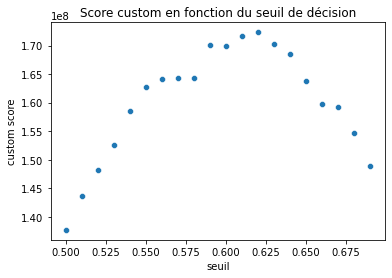

In [168]:
model = gridsearch_lgbm_smote_opt_custom
y_proba = model.predict_proba(X_test)[:, 1]
choix_seuil = pd.DataFrame()
# plt.figure(figsize=(21, 50))
compteur = 1
for seuil in np.arange(0.5, 0.7, 0.01):
    masque = y_proba > seuil
    y_pred = y_proba.copy()
    y_pred[masque] = 1
    y_pred[~masque] = 0
    score = custom_metric(y_true=y_test, y_pred=y_pred)
    result = pd.DataFrame([seuil, score]).T
    choix_seuil = choix_seuil.append(result)

choix_seuil.columns = ['seuil', 'custom score']
choix_seuil = choix_seuil.reset_index(drop=True)
# plt.subplot(7, 3, 21)
sns.scatterplot(data=choix_seuil, x='seuil', y='custom score')
plt.title('Score custom en fonction du seuil de décision')
plt.show()

In [169]:
choix_seuil

,seuil,custom score
0,0.50,1.377113e+08
1,0.51,1.437164e+08
2,0.52,1.481429e+08
3,0.53,1.525732e+08
4,0.54,1.585156e+08
5,0.55,1.627157e+08
6,0.56,1.641027e+08
7,0.57,1.642971e+08
8,0.58,1.642538e+08
9,0.59,1.701619e+08


In [170]:
# pour récupérer la proba de refus du credit
model = gridsearch_lgbm_smote_opt_custom
user_id = 100002
data_user = pd.DataFrame(data.loc[user_id,:]).T
y_proba_user = model.predict_proba(data_user)[:,1]
print(y_proba_user)

y_pred_user = model.predict(data_user)
print(y_pred_user)

if y_proba_user > 0.62:
    print('refus du prêt')
else:
    print("Acceptation du prêt")

[0.67900955]
[1.]
refus du prêt


In [200]:
user_id = 1
if user_id not in data.index:
    print('nok')
else:
    print('ok')

nok


In [171]:
# pour récupérer la proba de refus du credit
model = gridsearch_lgbm_smote_opt_custom.best_estimator_
user_id = 100002
data_user = pd.DataFrame(data.loc[user_id,:]).T
y_proba_user = model.predict_proba(data_user)[:,1]
print(y_proba_user)

y_pred_user = model.predict(data_user)
print(y_pred_user)

if y_proba_user > 0.62:
    print('refus du prêt')
else:
    print("Acceptation du prêt")

[0.67900955]
[1.]
refus du prêt


In [172]:
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler())]),
                                                  ['CNT_CHILDREN',
                                                   'AMT_INCOME_TOTAL',
                                                   'AMT_CREDIT', 'AMT_ANNUITY',
                                                   'AMT_GOODS_PRICE',
                                                   'REGION_POPULATION_RELATIVE',
                                                   'DAYS_BIRTH',
                                                   'DAYS_EMPLOYED',
                                                   'DAYS_REGISTRATION',
                                                   'DAYS_ID_PUBLISH',
                                                   'REGION_RATING_CLIENT_W_CITY',
                                                   'HOUR_A...
                                                                                 strategy='constant'))]),
                                                  ['FLAG_WORK_PHONE',
                                                   'FLAG_PHONE',
                                                   'REG_CITY_NOT_LIVE_CITY',
                                                   'REG_CITY_NOT_WORK_CITY',
                                                   'FLAG_DOCUMENT_3',
                                                   'FLAG_DOCUMENT_6',
                                                   'FLAG_DOCUMENT_13',
                                                   'FLAG_DOCUMENT_16',
                                                   'NAME_CONTRACT_TYPE',
                                                   'CODE_GENDER',
                                                   'FLAG_OWN_CAR',
                                                   'EMERGENCYSTATE_MODE'])])),
                ('lgbmclassifier',
                 LGBMClassifier(max_depth=15, num_leaves=35, random_state=10,
                                reg_alpha=0, reg_lambda=0))])

 # export

In [196]:
type(data['NAME_CONTRACT_TYPE'])

pandas.core.series.Series

In [197]:
data_model = {}
for col in data.columns:
    var_type = data[col].dtypes
    data_model.update({col: (var_type, Field(...))})
data_model
dump(data_model, job_dir + '/dataModel.joblib')

['./JOBLIB/dataModel.joblib']

In [191]:
len(data.columns)

125

In [198]:
# data_model = fct.creation_class_model(data)

data_model = {}
for i in range(len(data.dtypes)):
    name = data.dtypes.index[i]
    var_type = type(data.iloc[0, i])
    # var_type = data.iloc[0,i].dtypes
    print(name, var_type)
    data_model.update({name: (var_type, Field(...))})

data_model

dump(data_model, job_dir + '/dataModel.joblib')


NAME_CONTRACT_TYPE <class 'int'>
CODE_GENDER <class 'int'>
FLAG_OWN_CAR <class 'int'>
CNT_CHILDREN <class 'numpy.float64'>
AMT_INCOME_TOTAL <class 'numpy.float64'>
AMT_CREDIT <class 'numpy.float64'>
AMT_ANNUITY <class 'numpy.float64'>
AMT_GOODS_PRICE <class 'numpy.float64'>
REGION_POPULATION_RELATIVE <class 'numpy.float64'>
DAYS_BIRTH <class 'numpy.float64'>
DAYS_EMPLOYED <class 'numpy.float64'>
DAYS_REGISTRATION <class 'numpy.float64'>
DAYS_ID_PUBLISH <class 'numpy.float64'>
FLAG_WORK_PHONE <class 'int'>
FLAG_PHONE <class 'int'>
REGION_RATING_CLIENT_W_CITY <class 'numpy.float64'>
HOUR_APPR_PROCESS_START <class 'numpy.float64'>
REG_CITY_NOT_LIVE_CITY <class 'int'>
REG_CITY_NOT_WORK_CITY <class 'int'>
EXT_SOURCE_2 <class 'numpy.float64'>
EXT_SOURCE_3 <class 'numpy.float64'>
EMERGENCYSTATE_MODE <class 'int'>
DEF_30_CNT_SOCIAL_CIRCLE <class 'numpy.float64'>
DAYS_LAST_PHONE_CHANGE <class 'numpy.float64'>
FLAG_DOCUMENT_3 <class 'int'>
FLAG_DOCUMENT_6 <class 'int'>
FLAG_DOCUMENT_13 <class 'i

['./JOBLIB/dataModel.joblib']

In [182]:
data.dtypes

NAME_CONTRACT_TYPE                object
CODE_GENDER                       object
FLAG_OWN_CAR                      object
CNT_CHILDREN                     float64
AMT_INCOME_TOTAL                 float64
                                  ...   
INSTAL_PAYMENT_DIFF_SUM          float64
INSTAL_AMT_PAYMENT_MIN           float64
INSTAL_AMT_PAYMENT_MEAN          float64
INSTAL_AMT_PAYMENT_SUM           float64
INSTAL_DAYS_ENTRY_PAYMENT_SUM    float64
Length: 125, dtype: object

In [178]:
data_model

{'NAME_CONTRACT_TYPE': (int, FieldInfo(default=Ellipsis, extra={})),
 'CODE_GENDER': (int, FieldInfo(default=Ellipsis, extra={})),
 'FLAG_OWN_CAR': (int, FieldInfo(default=Ellipsis, extra={})),
 'CNT_CHILDREN': (numpy.float64, FieldInfo(default=Ellipsis, extra={})),
 'AMT_INCOME_TOTAL': (numpy.float64, FieldInfo(default=Ellipsis, extra={})),
 'AMT_CREDIT': (numpy.float64, FieldInfo(default=Ellipsis, extra={})),
 'AMT_ANNUITY': (numpy.float64, FieldInfo(default=Ellipsis, extra={})),
 'AMT_GOODS_PRICE': (numpy.float64, FieldInfo(default=Ellipsis, extra={})),
 'REGION_POPULATION_RELATIVE': (numpy.float64,
  FieldInfo(default=Ellipsis, extra={})),
 'DAYS_BIRTH': (numpy.float64, FieldInfo(default=Ellipsis, extra={})),
 'DAYS_EMPLOYED': (numpy.float64, FieldInfo(default=Ellipsis, extra={})),
 'DAYS_REGISTRATION': (numpy.float64, FieldInfo(default=Ellipsis, extra={})),
 'DAYS_ID_PUBLISH': (numpy.float64, FieldInfo(default=Ellipsis, extra={})),
 'FLAG_WORK_PHONE': (int, FieldInfo(default=Ellip